In [1]:
# --- Standard Library ---
import os
import json
import gc
from functools import reduce
from typing import List

# --- Data Handling ---
import numpy as np
import pandas as pd
import polars as pl
import joblib

# --- Visualization ---
import matplotlib.pyplot as plt

# --- Machine Learning ---
import optuna
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- Parallel Processing ---
from joblib import Parallel, delayed
from more_itertools import chunked

# --- PyTorch (if needed) ---
#import torch.nn as nn


In [ ]:
df_full = pd.read_parquet('./data/product_interm_LGBM.parquet', engine='fastparquet')
# Separar conjuntos
df_train = df_full[df_full['PERIODO'] <= 201812].copy()
df_val = df_full[df_full['PERIODO'].between(201901, 201909)].copy()
df_test = df_full[(df_full['PERIODO'] == 201910)].copy()
df_target_201912 = df_full[df_full['PERIODO'] == 201912].copy()
gc.collect()

In [4]:
def total_forecast_error(y_true, y_pred):
    numerador = np.sum(np.abs(y_true - y_pred))
    denominador = np.sum(y_true)
    if denominador == 0:
        return np.nan
    return numerador / denominador


In [5]:
def inv_transform_log1p(arr):
    # Si tus datos pueden ser negativos y le hiciste log1p sobre abs(x) * sign(x), esta lógica es correcta:
    orig_vals = np.sign(arr) * np.expm1(np.abs(arr))
    return orig_vals


In [6]:
import gc
import optuna
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- SETUP ---
target_col = 'CLASE_LOG1P'
feature_cols = [col for col in df_train.columns if col != target_col]

X_tr = df_train[feature_cols]
y_tr = df_train[target_col]
X_val = df_val[feature_cols]
y_val = df_val[target_col]

In [7]:

# --- 1. Definir función objetivo ---
def objective_lgbm(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.0005, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "max_depth": trial.suggest_int("max_depth", 4, 32),
        "n_estimators": trial.suggest_int("n_estimators", 800, 3000),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 120),
        "subsample": trial.suggest_float("subsample", 0.7, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 0.95),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 100.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 100.0, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        "random_state": trial.number,
        "n_jobs": -1,
        "verbosity": -1,
        "objective": "mae",
        "random_state": 42
    }
    model = LGBMRegressor(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[early_stopping(stopping_rounds=100, verbose=False)],
    )
    preds = model.predict(X_val)
    
    y_val_orig = inv_transform_log1p(y_val.values)
    preds_orig = inv_transform_log1p(preds)

    tfe = total_forecast_error(y_val_orig, preds_orig)
    trial.set_user_attr("mae", mean_absolute_error(y_val_orig, preds_orig))
    gc.collect()
    return tfe

# --- 2. Crear estudio con almacenamiento en SQLite ---
optuna_db_path = "sqlite:///optuna_lgbm_study.db"
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=101),
    storage=optuna_db_path,
    study_name="lgbm_tfe_optim",
    load_if_exists=True  # si ya existe, lo continúa
)

# --- 3. Ejecutar la optimización ---
N_MODELS = 50
N_TRIALS = 500

study.optimize(objective_lgbm, n_trials=N_TRIALS, n_jobs=28, show_progress_bar=True)

# --- 4. Extraer y guardar los mejores parámetros ---
trials_df = study.trials_dataframe()
trials_df["mae"] = [t.user_attrs.get("mae", np.nan) for t in study.trials]

top_lgbm_trials = trials_df.sort_values("value").head(N_MODELS)

final_configs = []
for i, row in top_lgbm_trials.iterrows():
    params = row.filter(like='params_').to_dict()
    params = {k.replace('params_', ''): v for k, v in params.items()}
    for p in ["num_leaves", "max_depth", "n_estimators", "min_child_samples"]:
        params[p] = int(params[p])
    params["random_state"] = int(row["number"])
    params["n_jobs"] = -1
    params["verbosity"] = -1
    final_configs.append(params)

# --- 5. Guardar en archivos externos ---
top_lgbm_trials.to_csv("optuna_lgbm_trials.csv", index=False)

with open("lgbm_ensemble_configs.json", "w") as f:
    json.dump(final_configs, f, indent=2)

# --- 6. Resumen en consola ---
print(f"Top 50 TFE: {top_lgbm_trials['value'].head(50).values}")
print(f"Top 50 MAE: {top_lgbm_trials['mae'].head(50).values}")
print(final_configs)


[I 2025-07-16 21:16:24,562] Using an existing study with name 'lgbm_tfe_optim' instead of creating a new one.


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-07-16 21:19:29,141] Trial 71 finished with value: 0.2536903649243996 and parameters: {'learning_rate': 0.024530908654785893, 'num_leaves': 59, 'max_depth': 20, 'n_estimators': 2994, 'min_child_samples': 33, 'subsample': 0.7901253387831785, 'colsample_bytree': 0.8095261489326865, 'reg_alpha': 0.1108772287601346, 'reg_lambda': 2.965406911691412, 'min_split_gain': 0.5001325914185003}. Best is trial 27 with value: 0.24959855147659546.
[I 2025-07-16 21:19:43,940] Trial 88 finished with value: 0.25258846407629937 and parameters: {'learning_rate': 0.026359350508570883, 'num_leaves': 55, 'max_depth': 21, 'n_estimators': 2505, 'min_child_samples': 39, 'subsample': 0.7918171008137299, 'colsample_bytree': 0.8083293225813997, 'reg_alpha': 0.11756612272106289, 'reg_lambda': 2.3674865994688696, 'min_split_gain': 0.5549603834354462}. Best is trial 27 with value: 0.24959855147659546.
[I 2025-07-16 21:19:48,320] Trial 67 finished with value: 0.2524702895781659 and parameters: {'learning_rate': 

In [8]:
X_full = pd.concat([df_train, df_val], ignore_index=True)[feature_cols]
y_full = pd.concat([df_train[target_col], df_val[target_col]], ignore_index=True)

In [9]:
import pandas as pd

top_lgbm_trials = pd.read_csv("optuna_lgbm_trials.csv")


In [10]:
import json

with open("lgbm_ensemble_configs.json", "r") as f:
    final_configs = json.load(f)


In [11]:
import joblib
from lightgbm import LGBMRegressor

def train_and_save_model(i, params, X_full, y_full):
    print(f"Entrenando modelo {i+1}/50...")
    params = params.copy()  # Para no modificar el original en la lista
    params["objective"] = "mae"  # Forzar MAE aunque el config no lo tenga
    model = LGBMRegressor(**params)
    model.fit(X_full, y_full)
    joblib.dump(model, f'lgbm_model_{i+1:02d}.pkl')
    return f"Modelo {i+1} terminado"


results = joblib.Parallel(n_jobs=20)(
    joblib.delayed(train_and_save_model)(i, params, X_full, y_full)
    for i, params in enumerate(final_configs[:50])
)

print(results)
print("¡Entrenamiento y guardado de los 50 modelos finalizado!")


Entrenando modelo 2/50...
Entrenando modelo 3/50...
Entrenando modelo 8/50...
Entrenando modelo 20/50...
Entrenando modelo 11/50...
Entrenando modelo 1/50...
Entrenando modelo 18/50...
Entrenando modelo 7/50...
Entrenando modelo 5/50...
Entrenando modelo 4/50...
Entrenando modelo 6/50...
Entrenando modelo 9/50...
Entrenando modelo 17/50...
Entrenando modelo 15/50...
Entrenando modelo 12/50...
Entrenando modelo 14/50...
Entrenando modelo 16/50...
Entrenando modelo 10/50...
Entrenando modelo 13/50...
Entrenando modelo 19/50...
Entrenando modelo 21/50...
Entrenando modelo 22/50...
Entrenando modelo 23/50...
Entrenando modelo 24/50...
Entrenando modelo 25/50...
Entrenando modelo 26/50...
Entrenando modelo 27/50...
Entrenando modelo 28/50...
Entrenando modelo 29/50...
Entrenando modelo 30/50...
Entrenando modelo 31/50...
Entrenando modelo 32/50...
Entrenando modelo 33/50...
Entrenando modelo 34/50...
Entrenando modelo 35/50...
Entrenando modelo 36/50...
Entrenando modelo 37/50...
Entrenando

In [12]:
import joblib

# Cargar los 50 modelos LightGBM entrenados
lgbm_models = []
for i in range(1, 51):
    model = joblib.load(f'lgbm_model_{i:02d}.pkl')
    lgbm_models.append(model)


In [13]:
import numpy as np

# --- Predicción LightGBM (50 modelos) ---
lgbm_preds = []

feature_cols = [col for col in df_test.columns if col != target_col]

X_pred_lgbm = df_test[feature_cols]  # Si podés, asegurate que están en el mismo orden y tipo que en train

for i, model in enumerate(lgbm_models):
    print(f"Prediciendo LightGBM {i+1}/50...")
    preds = model.predict(X_pred_lgbm)
    lgbm_preds.append(preds)

lgbm_preds = np.stack(lgbm_preds).T  # shape (N, 50)

# --- Agregar predicciones LGBM al DataFrame existente con resultados de MLP ---
for i in range(50):
    df_test[f'lgbm_pred_LOG1P_{i+1}'] = lgbm_preds[:, i]


Prediciendo LightGBM 1/50...
Prediciendo LightGBM 2/50...
Prediciendo LightGBM 3/50...
Prediciendo LightGBM 4/50...
Prediciendo LightGBM 5/50...
Prediciendo LightGBM 6/50...
Prediciendo LightGBM 7/50...
Prediciendo LightGBM 8/50...
Prediciendo LightGBM 9/50...
Prediciendo LightGBM 10/50...
Prediciendo LightGBM 11/50...
Prediciendo LightGBM 12/50...
Prediciendo LightGBM 13/50...
Prediciendo LightGBM 14/50...
Prediciendo LightGBM 15/50...
Prediciendo LightGBM 16/50...
Prediciendo LightGBM 17/50...
Prediciendo LightGBM 18/50...
Prediciendo LightGBM 19/50...
Prediciendo LightGBM 20/50...
Prediciendo LightGBM 21/50...
Prediciendo LightGBM 22/50...
Prediciendo LightGBM 23/50...
Prediciendo LightGBM 24/50...
Prediciendo LightGBM 25/50...
Prediciendo LightGBM 26/50...
Prediciendo LightGBM 27/50...
Prediciendo LightGBM 28/50...
Prediciendo LightGBM 29/50...
Prediciendo LightGBM 30/50...
Prediciendo LightGBM 31/50...
Prediciendo LightGBM 32/50...
Prediciendo LightGBM 33/50...
Prediciendo LightGB

In [14]:
import numpy as np

# Seleccioná las columnas de predicción
lgbm_pred_cols = [col for col in df_test.columns if col.startswith('lgbm_pred_LOG1P_')]

# Calcula métricas fila a fila
df_test['lgbm_pred_mean'] = df_test[lgbm_pred_cols].mean(axis=1)
df_test['lgbm_pred_median'] = df_test[lgbm_pred_cols].median(axis=1)
df_test['lgbm_pred_std'] = df_test[lgbm_pred_cols].std(axis=1)
df_test['lgbm_pred_q25'] = df_test[lgbm_pred_cols].quantile(0.25, axis=1)
df_test['lgbm_pred_q75'] = df_test[lgbm_pred_cols].quantile(0.75, axis=1)
df_test['lgbm_pred_min'] = df_test[lgbm_pred_cols].min(axis=1)
df_test['lgbm_pred_max'] = df_test[lgbm_pred_cols].max(axis=1)
df_test['lgbm_pred_iqr'] = df_test['lgbm_pred_q75'] - df_test['lgbm_pred_q25']


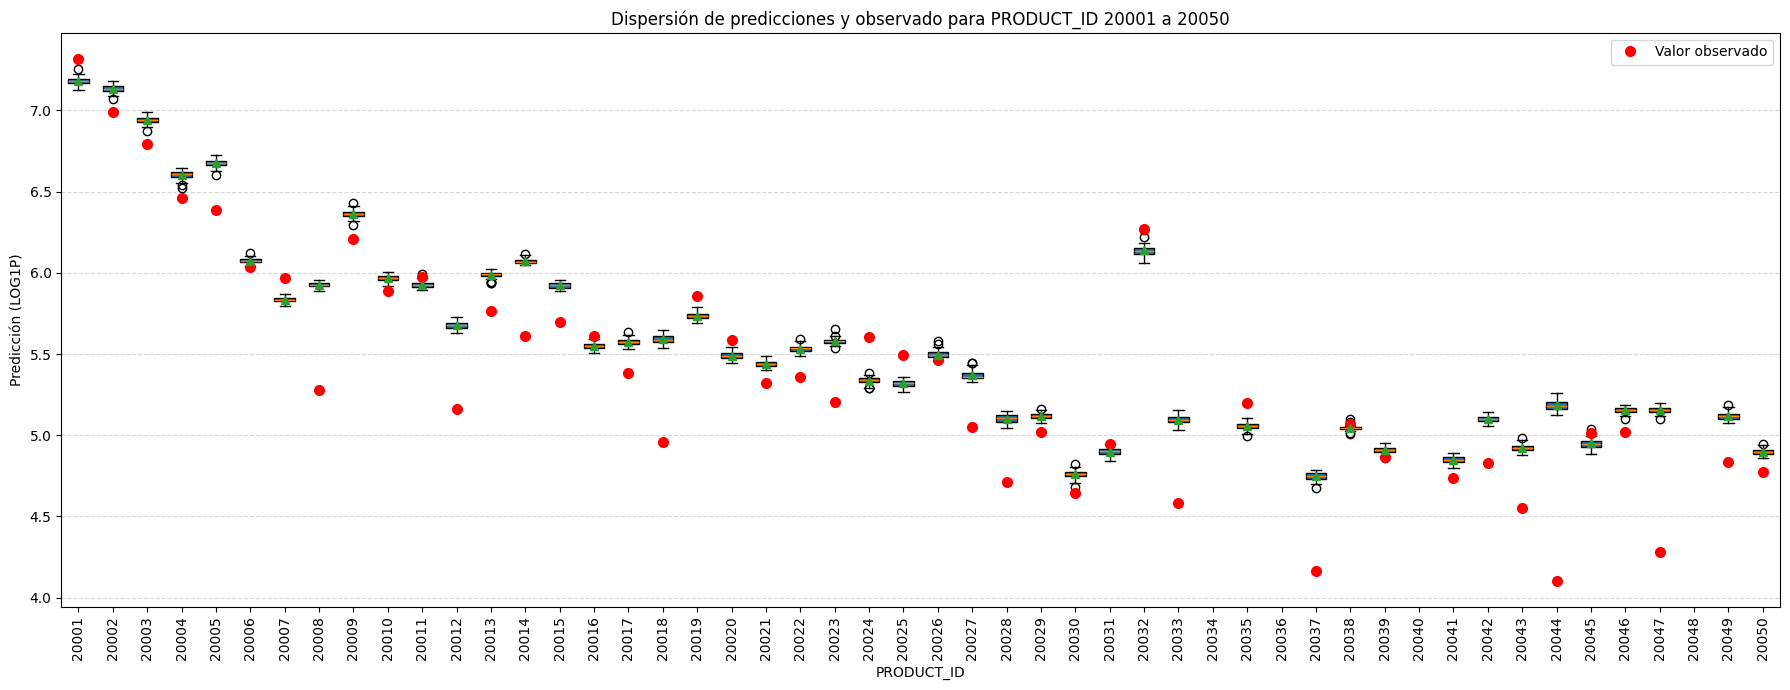

In [15]:
import matplotlib.pyplot as plt

# Rango de productos a analizar
productos = range(20001, 20051)

plt.figure(figsize=(18, 7))

box_data = []
obs_pos = []
obs_vals = []

for i, pid in enumerate(productos, 1):
    # Todas las predicciones fila a fila para ese producto
    vals = df_test[df_test['PRODUCT_ID'] == pid][lgbm_pred_cols].values.flatten()
    box_data.append(vals)
    # Todos los valores observados para ese producto
    vals_obs = df_test[df_test['PRODUCT_ID'] == pid]['CLASE_LOG1P'].values
    for obs in vals_obs:
        obs_pos.append(i)
        obs_vals.append(obs)

# Dibujar los boxplots
plt.boxplot(box_data, positions=range(1, len(productos)+1), widths=0.6, patch_artist=True, showmeans=True)

# Dibujar todos los valores observados como círculos rojos
plt.plot(obs_pos, obs_vals, 'ro', markersize=7, label='Valor observado')

plt.title('Dispersión de predicciones y observado para PRODUCT_ID 20001 a 20050')
plt.ylabel('Predicción (LOG1P)')
plt.xlabel('PRODUCT_ID')
plt.xticks(range(1, len(productos)+1), [str(pid) for pid in productos], rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()




/tmp/ipykernel_22697/4101327305.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data.T, labels=df_plot['PRODUCT_ID'], showfliers=True)


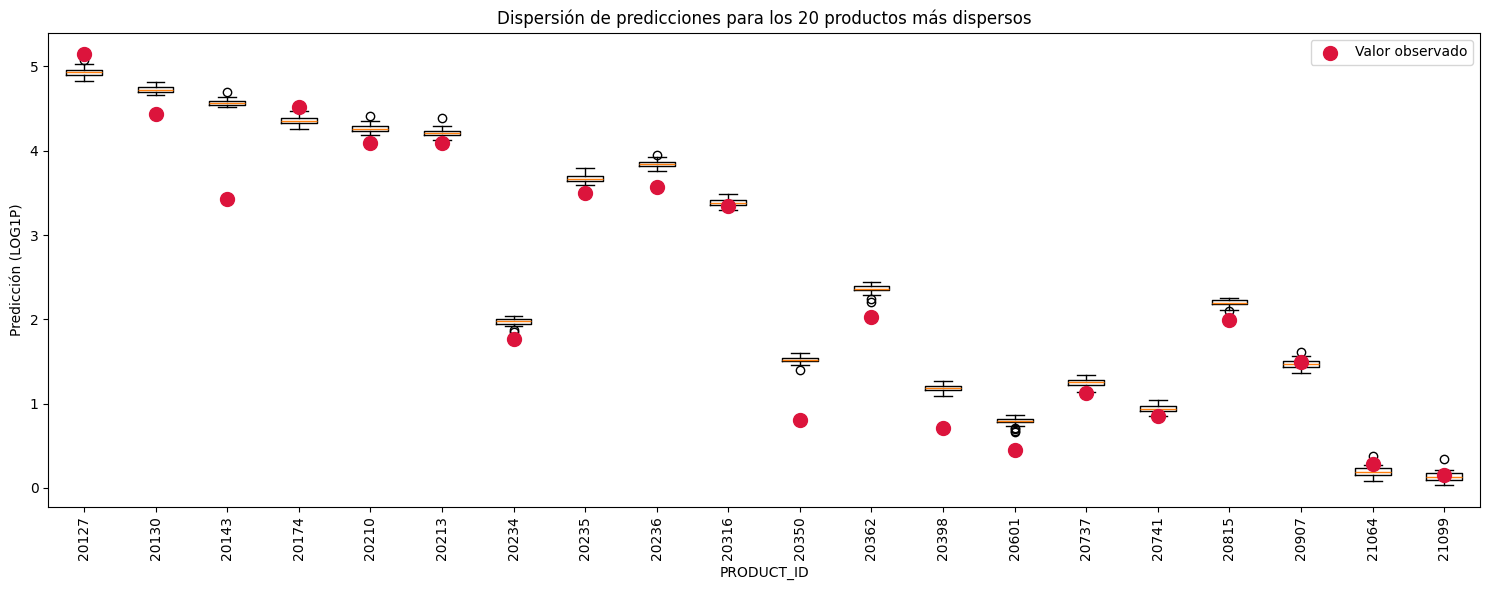

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calcula la dispersión (std) para cada producto
pred_cols = [c for c in df_test.columns if c.startswith('lgbm_pred_LOG1P_')]
df_test['pred_std'] = df_test[pred_cols].std(axis=1)
top_n = 20
productos_disp = df_test.sort_values('pred_std', ascending=False)['PRODUCT_ID'].unique()[:top_n]

# Subset de los productos seleccionados
df_plot = df_test[df_test['PRODUCT_ID'].isin(productos_disp)].copy()
df_plot = df_plot[['PRODUCT_ID', 'CLASE_LOG1P'] + pred_cols]

# Boxplots
plt.figure(figsize=(15, 6))
data = df_plot[pred_cols].values  # Solo las columnas de predicción
positions = np.arange(1, len(df_plot)+1)

plt.boxplot(data.T, labels=df_plot['PRODUCT_ID'], showfliers=True)

# Marcar el valor observado con un punto rojo para cada producto
for idx, (prod, y_true) in enumerate(zip(df_plot['PRODUCT_ID'], df_plot['CLASE_LOG1P'])):
    plt.scatter(idx+1, y_true, color='crimson', marker='o', s=100, zorder=5, label='Valor observado' if idx==0 else "")

plt.xticks(rotation=90)
plt.xlabel('PRODUCT_ID')
plt.ylabel('Predicción (LOG1P)')
plt.title(f'Dispersión de predicciones para los {top_n} productos más dispersos')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()



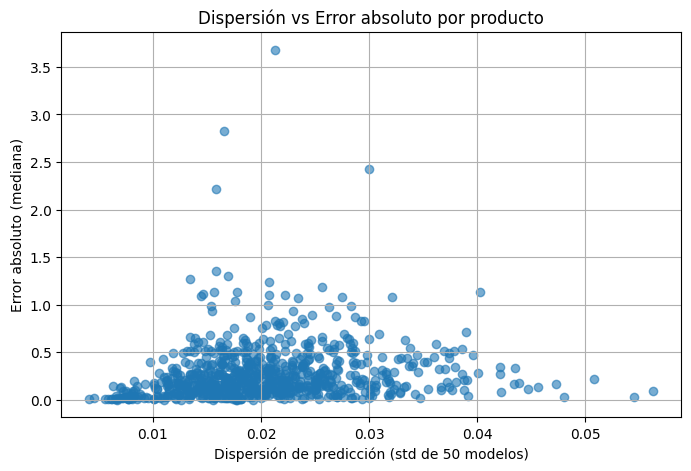

In [17]:
# Calcula la predicción central y la dispersión
df_test['pred_median'] = df_test[pred_cols].median(axis=1)
df_test['pred_mean'] = df_test[pred_cols].mean(axis=1)
df_test['pred_std'] = df_test[pred_cols].std(axis=1)

# Error absoluto respecto al real
df_test['abs_err_median'] = (df_test['pred_median'] - df_test['CLASE_LOG1P']).abs()
df_test['abs_err_mean'] = (df_test['pred_mean'] - df_test['CLASE_LOG1P']).abs()

plt.figure(figsize=(8,5))
plt.scatter(df_test['pred_std'], df_test['abs_err_median'], alpha=0.6)
plt.xlabel('Dispersión de predicción (std de 50 modelos)')
plt.ylabel('Error absoluto (mediana)')
plt.title('Dispersión vs Error absoluto por producto')
plt.grid(True)
plt.show()


In [18]:
pred_cols = [c for c in df_test.columns if c.startswith('lgbm_pred_LOG1P_')]
df_test['CLASE_TN'] = inv_transform_log1p(df_test['CLASE_LOG1P'].values)
# Tomar las 50 columnas como una matriz
preds_orig = inv_transform_log1p(df_test[pred_cols].values)  # Deshace log1p

# Crear nuevas columnas en el DataFrame con los valores originales
for i, col in enumerate(pred_cols):
    df_test[col.replace('LOG1P', 'TN')] = preds_orig[:, i]


/tmp/ipykernel_22697/3206997604.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[col.replace('LOG1P', 'TN')] = preds_orig[:, i]
/tmp/ipykernel_22697/3206997604.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[col.replace('LOG1P', 'TN')] = preds_orig[:, i]
/tmp/ipykernel_22697/3206997604.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

In [19]:
# Las nuevas columnas de predicción en escala original
pred_cols_tn = [c for c in df_test.columns if c.startswith('lgbm_pred_TN_')]
df_test['pred_std_tn'] = df_test[pred_cols_tn].std(axis=1)
df_test['pred_median_tn'] = df_test[pred_cols_tn].median(axis=1)
df_test['abs_error_median_tn'] = np.abs(df_test['pred_median_tn'] - df_test['CLASE_TN'])


/tmp/ipykernel_22697/2174904353.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['pred_std_tn'] = df_test[pred_cols_tn].std(axis=1)
/tmp/ipykernel_22697/2174904353.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['pred_median_tn'] = df_test[pred_cols_tn].median(axis=1)
/tmp/ipykernel_22697/2174904353.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

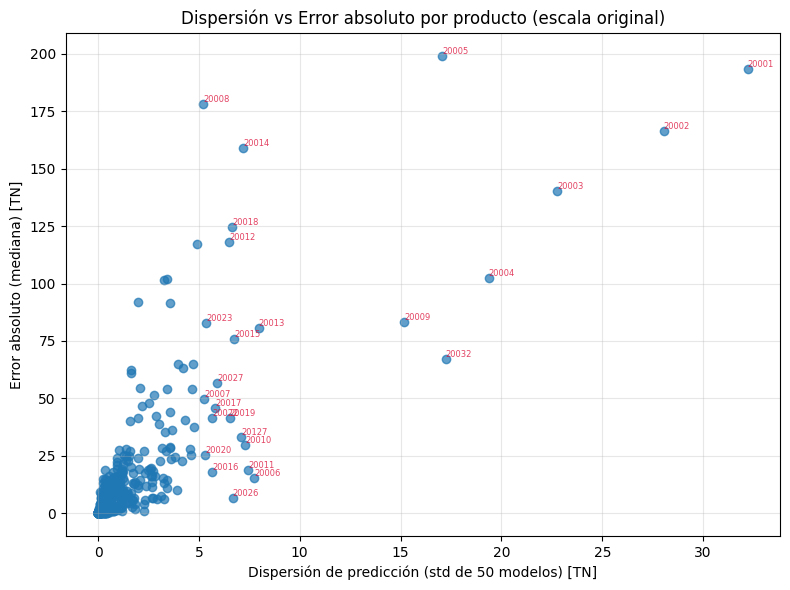

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df_test['pred_std_tn'], df_test['abs_error_median_tn'], alpha=0.7)

# Etiquetar solo los puntos más dispersos
umbral_disp = 5  # Cambia el umbral si querés más o menos etiquetas
df_label = df_test[df_test['pred_std_tn'] > umbral_disp]

for _, row in df_label.iterrows():
    plt.text(
        row['pred_std_tn'],
        row['abs_error_median_tn'],
        f"{int(row['PRODUCT_ID'])}",  # fuerza a int sin decimales
        fontsize=6,                  # más pequeño
        color='crimson',
        alpha=0.8,
        ha='left',
        va='bottom'
    )

plt.xlabel('Dispersión de predicción (std de 50 modelos) [TN]')
plt.ylabel('Error absoluto (mediana) [TN]')
plt.title('Dispersión vs Error absoluto por producto (escala original)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




/tmp/ipykernel_22697/1523536016.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


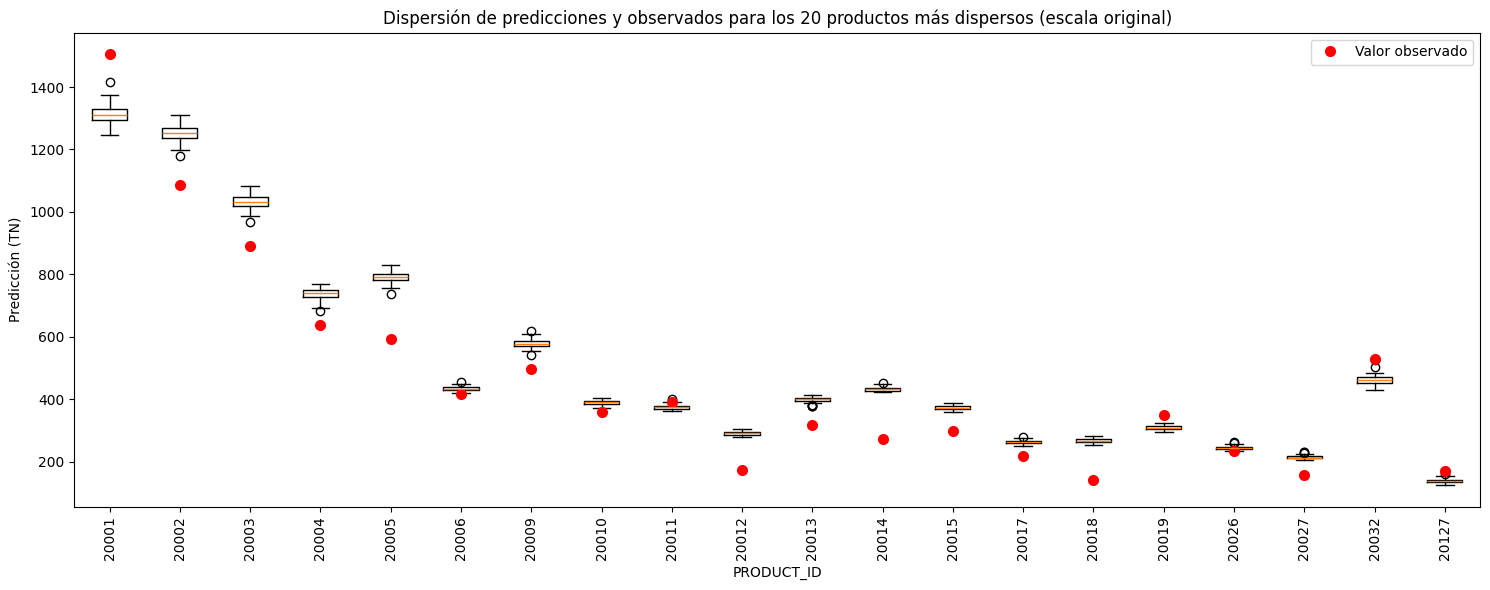

In [25]:
import matplotlib.pyplot as plt

# Top N más dispersos
top_n = 20
productos_disp = df_test.sort_values('pred_std_tn', ascending=False)['PRODUCT_ID'].unique()[:top_n]
df_plot = df_test[df_test['PRODUCT_ID'].isin(productos_disp)].copy()

plt.figure(figsize=(15, 6))

# Armar datos para el boxplot
data = [row[1:] for row in df_plot[['PRODUCT_ID'] + pred_cols_tn].values]  # omite PRODUCT_ID
labels = df_plot['PRODUCT_ID'].astype(str).values

# Plotear los boxplots
plt.boxplot(data, labels=labels, showfliers=True)

# Sobreponer los valores observados (puede haber más de uno por producto, si hay varias filas)
for idx, prod_id in enumerate(df_plot['PRODUCT_ID']):
    valores_reales = df_test[df_test['PRODUCT_ID'] == prod_id]['CLASE_TN'].values
    for vreal in valores_reales:
        plt.plot(idx + 1, vreal, 'ro', markersize=7, label='Valor observado' if idx == 0 else "")

plt.xticks(rotation=90)
plt.xlabel('PRODUCT_ID')
plt.ylabel('Predicción (TN)')
plt.title(f'Dispersión de predicciones y observados para los {top_n} productos más dispersos (escala original)')

# Mostrar solo un label para 'Valor observado'
handles, labels = plt.gca().get_legend_handles_labels()
if handles:
    plt.legend([handles[0]], ['Valor observado'])

plt.tight_layout()
plt.show()



In [26]:
top_n = 30

# Top por dispersión
top_disp = df_test.sort_values('pred_std_tn', ascending=False).head(top_n)
print("Top 30 productos por dispersión:")
print(top_disp[['PRODUCT_ID', 'pred_std_tn', 'abs_error_median_tn', 'CLASE_TN']])

# Top por error absoluto
top_error = df_test.sort_values('abs_error_median_tn', ascending=False).head(top_n)
print("\nTop 30 productos por error absoluto:")
print(top_error[['PRODUCT_ID', 'pred_std_tn', 'abs_error_median_tn', 'CLASE_TN']])



Top 30 productos por dispersión:
      PRODUCT_ID  pred_std_tn  abs_error_median_tn    CLASE_TN
2          20001    32.198765           193.234669  1504.68856
38         20002    28.041769           166.377000  1087.30855
74         20003    22.760859           140.131827   891.25641
110        20004    19.369958           102.298843   637.84826
1118       20032    17.235532            67.011524   527.79811
146        20005    17.054321           199.122972   592.53573
290        20009    15.184539            83.072084   495.03574
434        20013     7.971442            80.756768   318.00951
182        20006     7.742320            15.166186   417.23228
362        20011     7.449069            18.861492   392.25186
326        20010     7.281564            29.788660   359.59998
470        20014     7.187881           159.147116   272.02812
3902       20127     7.094296            33.085166   170.32792
506        20015     6.755892            75.785243   297.27663
902        20026     6

In [27]:
import numpy as np
import pandas as pd

# 1. Identificá las columnas de predicción
pred_cols_tn = [c for c in df_test.columns if c.startswith('lgbm_pred_TN_')]

# 2. Calculá media y mediana de las predicciones
df_test['ensemble_median'] = df_test[pred_cols_tn].median(axis=1)
df_test['ensemble_mean']   = df_test[pred_cols_tn].mean(axis=1)

# 3. Calculá el MAE para ambas estrategias
mae_median = np.mean(np.abs(df_test['ensemble_median'] - df_test['CLASE_TN']))
mae_mean   = np.mean(np.abs(df_test['ensemble_mean']   - df_test['CLASE_TN']))

print(f"MAE usando la **mediana** de 50 modelos: {mae_median:.3f} TN")
print(f"MAE usando la **media** de 50 modelos:   {mae_mean:.3f} TN")

# 4. Si querés comparar producto por producto:
df_test['error_median'] = np.abs(df_test['ensemble_median'] - df_test['CLASE_TN'])
df_test['error_mean']   = np.abs(df_test['ensemble_mean']   - df_test['CLASE_TN'])

print("\nTop 10 productos donde la media le gana a la mediana:")
print(df_test[df_test['error_mean'] < df_test['error_median']][['PRODUCT_ID', 'error_median', 'error_mean']].sort_values('error_median', ascending=False).head(10))


MAE usando la **mediana** de 50 modelos: 8.536 TN
MAE usando la **media** de 50 modelos:   8.545 TN

Top 10 productos donde la media le gana a la mediana:
      PRODUCT_ID  error_median  error_mean
146        20005    199.122972  198.154374
38         20002    166.377000  164.718323
398        20012    118.071127  117.838857
110        20004    102.298843   99.378470
1525       20047    101.352406  101.070154
3135       20100     92.054719   91.882803
2706       20085     91.698612   91.234218
434        20013     80.756768   79.569442
506        20015     75.785243   75.595667
1118       20032     67.011524   65.595327


/tmp/ipykernel_22697/245051272.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['ensemble_median'] = df_test[pred_cols_tn].median(axis=1)
/tmp/ipykernel_22697/245051272.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['ensemble_mean']   = df_test[pred_cols_tn].mean(axis=1)
/tmp/ipykernel_22697/245051272.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

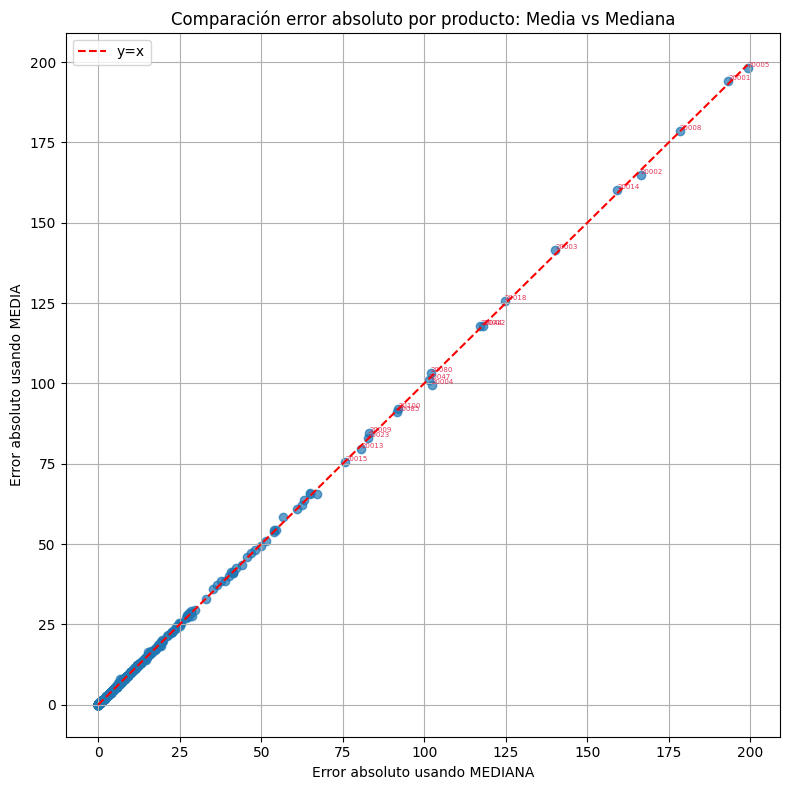

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(df_test['error_median'], df_test['error_mean'], alpha=0.7)

plt.plot(
    [df_test['error_median'].min(), df_test['error_median'].max()],
    [df_test['error_median'].min(), df_test['error_median'].max()],
    'r--', label='y=x'
)

# Etiquetar PRODUCT_ID donde error_median > 75 o error_mean > 75
for _, row in df_test.iterrows():
    if row['error_median'] > 75 or row['error_mean'] > 75:
        plt.text(
            row['error_median'],
            row['error_mean'],
            str(int(row['PRODUCT_ID'])),
            fontsize=5,
            color='crimson',
            alpha=0.85,
            ha='left',
            va='bottom'
        )

plt.xlabel('Error absoluto usando MEDIANA')
plt.ylabel('Error absoluto usando MEDIA')
plt.title('Comparación error absoluto por producto: Media vs Mediana')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



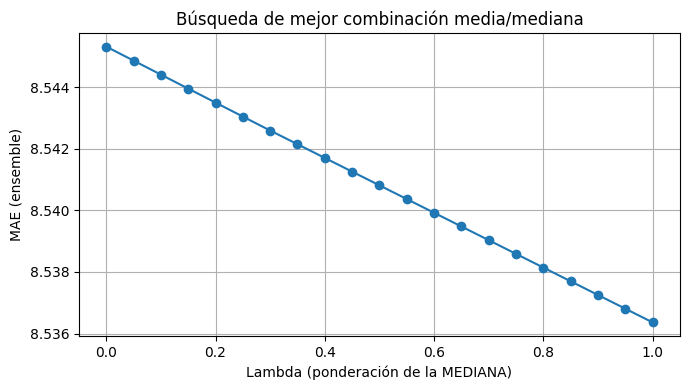

Mejor lambda = 1.00 (MAE=8.536 TN)


In [29]:
import numpy as np

lambdas = np.linspace(0, 1, 21)
maes = []

for l in lambdas:
    pred = l * df_test['ensemble_median'] + (1 - l) * df_test['ensemble_mean']
    mae = np.mean(np.abs(pred - df_test['CLASE_TN']))
    maes.append(mae)

plt.figure(figsize=(7, 4))
plt.plot(lambdas, maes, marker='o')
plt.xlabel('Lambda (ponderación de la MEDIANA)')
plt.ylabel('MAE (ensemble)')
plt.title('Búsqueda de mejor combinación media/mediana')
plt.grid(True)
plt.tight_layout()
plt.show()

best_lambda = lambdas[np.argmin(maes)]
print(f"Mejor lambda = {best_lambda:.2f} (MAE={min(maes):.3f} TN)")


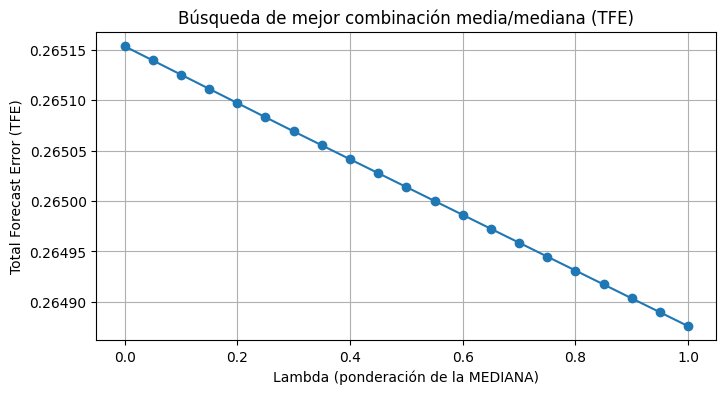

Mejor lambda: 1.00  ->  TFE = 0.264876


In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Tu función de métrica
def total_forecast_error(y_true, y_pred):
    numerador = np.sum(np.abs(y_true - y_pred))
    denominador = np.sum(y_true)
    if denominador == 0:
        return np.nan
    return numerador / denominador 

# Suponiendo que en tu df_test ya tenés:
# 'ensemble_median', 'ensemble_mean', y la observación real 'CLASE_TN'
lambdas = np.linspace(0, 1, 21)
tfe_scores = []

for l in lambdas:
    y_pred = l * df_test['ensemble_median'] + (1 - l) * df_test['ensemble_mean']
    tfe = total_forecast_error(df_test['CLASE_TN'].values, y_pred.values)
    tfe_scores.append(tfe)

plt.figure(figsize=(8, 4))
plt.plot(lambdas, tfe_scores, marker='o')
plt.xlabel('Lambda (ponderación de la MEDIANA)')
plt.ylabel('Total Forecast Error (TFE)')
plt.title('Búsqueda de mejor combinación media/mediana (TFE)')
plt.grid(True)
plt.show()

# Mejor lambda encontrado y su TFE
best_idx = np.argmin(tfe_scores)
print(f"Mejor lambda: {lambdas[best_idx]:.2f}  ->  TFE = {tfe_scores[best_idx]:.6f}")


In [ ]:
print(df_test.columns.tolist())

In [31]:
import pandas as pd
import numpy as np

# Si ensemble_median es UNA predicción por producto (no por fila):
# Entonces podés hacer así, suponiendo que tenés una única fila por PRODUCT_ID en df_test:
df_test['abs_error_median'] = np.abs(df_test['ensemble_median'] - df_test['CLASE_TN'])

# Ordenar por el error absoluto de la mediana, descendente (de mayor a menor error)
df_ordenado = df_test.sort_values('abs_error_median', ascending=False)[['PRODUCT_ID', 'ensemble_median', 'CLASE_TN', 'abs_error_median']]

# A df_ordenado agregar el desvio estándar de las predicciones
df_ordenado['pred_std'] = df_test[pred_cols_tn].std(axis=1)

print(df_ordenado.head(50))
df_ordenado.to_csv('validacion_lgbm_ordenadas.csv', index=False)

      PRODUCT_ID  ensemble_median    CLASE_TN  abs_error_median   pred_std
146        20005       791.658702   592.53573        199.122972  17.054321
2          20001      1311.453891  1504.68856        193.234669  32.198765
254        20008       373.648129   195.36854        178.279589   5.223399
38         20002      1253.685550  1087.30855        166.377000  28.041769
470        20014       431.175236   272.02812        159.147116   7.187881
74         20003      1031.388237   891.25641        140.131827  22.760859
614        20018       266.354420   141.63570        124.718720   6.641644
398        20012       291.201167   173.13004        118.071127   6.500261
1417       20044       176.788228    59.61747        117.170758   4.920400
110        20004       740.147103   637.84826        102.298843  19.369958
2562       20080       110.843103     8.84426        101.998843   3.426893
1525       20047       172.780026    71.42762        101.352406   3.282727
3135       20100        9

/tmp/ipykernel_22697/1387387907.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['abs_error_median'] = np.abs(df_test['ensemble_median'] - df_test['CLASE_TN'])


In [32]:
# Calcula el TFE por producto usando media y mediana
tfe_prod_median = []
tfe_prod_mean = []

for pid, subdf in df_test.groupby('PRODUCT_ID'):
    tfe_median = total_forecast_error(subdf['CLASE_TN'].values, subdf['ensemble_median'].values)
    tfe_mean = total_forecast_error(subdf['CLASE_TN'].values, subdf['ensemble_mean'].values)
    tfe_prod_median.append((pid, tfe_median))
    tfe_prod_mean.append((pid, tfe_mean))

df_tfe = pd.DataFrame({
    'PRODUCT_ID': [pid for pid, _ in tfe_prod_median],
    'TFE_median': [tfe for _, tfe in tfe_prod_median],
    'TFE_mean': [tfe for _, tfe in tfe_prod_mean]
})
df_tfe['TFE_diff'] = df_tfe['TFE_median'] - df_tfe['TFE_mean']

# Top 10 productos donde la media mejora más vs la mediana
print(df_tfe.sort_values('TFE_diff', ascending=False).head(10))


     PRODUCT_ID  TFE_median   TFE_mean  TFE_diff
532       20721   20.283240  20.048665  0.234575
89        20100   66.745011  66.620362  0.124649
779       21276    5.587348   5.514639  0.072709
446       20597    3.186225   3.119594  0.066631
778       21267    2.072879   2.011751  0.061128
773       21259    0.197370   0.145103  0.052266
747       21182    0.444835   0.400657  0.044178
716       21099    0.164282   0.121359  0.042922
772       21256    0.682641   0.642659  0.039983
762       21222    0.755352   0.716751  0.038601


In [33]:
# Calcular el TFE total para el conjunto de test
tfe_total_median = total_forecast_error(df_test['CLASE_TN'].values, df_test['ensemble_median'].values)
tfe_total_mean = total_forecast_error(df_test['CLASE_TN'].values, df_test['ensemble_mean'].values)
print(f"TFE total usando mediana: {tfe_total_median:.6f}")
print(f"TFE total usando media: {tfe_total_mean:.6f}")
print(np.sum(df_test['CLASE_TN'].values))  # Para verificar el denominador de TFE

TFE total usando mediana: 0.264876
TFE total usando media: 0.265154
25137.681330000003


In [35]:
import numpy as np
import pandas as pd

# --- Cargar tu DataFrame ---
# Debe contener: PRODUCT_ID, CLASE_TN (real), ensemble_median (predicción LGBM)
df_test = pd.read_csv("validacion_lgbm_ordenadas.csv")

# --- 1. Función y TFE total ---
def total_forecast_error(y_true, y_pred):
    numerador = np.sum(np.abs(y_true - y_pred))
    denominador = np.sum(y_true)
    return numerador / denominador if denominador != 0 else np.nan

tfe_total = total_forecast_error(df_test["CLASE_TN"], df_test["ensemble_median"])
print(f"TFE total (mediana LGBM): {tfe_total:.4f}")

# --- 2. Error absoluto y aporte individual al TFE ---
denominador = df_test["CLASE_TN"].sum()
df_test["abs_error_median"] = np.abs(df_test["CLASE_TN"] - df_test["ensemble_median"])
df_test["tfe_aporte"] = df_test["abs_error_median"] / denominador          # proporción (0–1)
df_test["tfe_pct"]    = df_test["tfe_aporte"] * 100                        # porcentaje

# --- 3. Ordenar por aporte y acumulado ---
df_test = df_test.sort_values("tfe_aporte", ascending=False).reset_index(drop=True)
df_test["aporte_acumulado"] = df_test["tfe_aporte"].cumsum()
df_test["aporte_acum_pct"]  = df_test["aporte_acumulado"] * 100

# --- 4. Productos que generan el 80 % del TFE ---
df_test["top_80pct_error"] = df_test["aporte_acumulado"] <= 0.80
productos_criticos = df_test.loc[df_test["top_80pct_error"], "PRODUCT_ID"].tolist()

# --- 5. Imprimir en formato “PID:XX %” ---
print("\nPRODUCT_ID y % del TFE (hasta cubrir el 80 % acumulado):")
formatted = df_test.loc[df_test["top_80pct_error"]] \
                   .apply(lambda r: f"{int(r['PRODUCT_ID'])}:{r['tfe_pct']:.1f}%", axis=1)
print(", ".join(formatted))

# --- 6. Guardar archivo con todo el detalle ---
df_test.to_csv("aporte_TFE_por_producto.csv",
               columns=["PRODUCT_ID", "CLASE_TN", "ensemble_median",
                        "abs_error_median", "tfe_pct", "aporte_acum_pct",
                        "top_80pct_error"],
               index=False)

print("\nArchivo 'aporte_TFE_por_producto.csv' generado.")


TFE total (mediana LGBM): 0.2649

PRODUCT_ID y % del TFE (hasta cubrir el 80 % acumulado):
20005:0.8%, 20001:0.8%, 20008:0.7%, 20002:0.7%, 20014:0.6%, 20003:0.6%, 20018:0.5%, 20012:0.5%, 20044:0.5%, 20004:0.4%, 20080:0.4%, 20047:0.4%, 20100:0.4%, 20085:0.4%, 20009:0.3%, 20023:0.3%, 20013:0.3%, 20015:0.3%, 20032:0.3%, 20033:0.3%, 20143:0.3%, 20024:0.3%, 20095:0.2%, 20072:0.2%, 20027:0.2%, 20077:0.2%, 20028:0.2%, 20094:0.2%, 20037:0.2%, 20007:0.2%, 20119:0.2%, 20070:0.2%, 20017:0.2%, 20061:0.2%, 20043:0.2%, 20019:0.2%, 20065:0.2%, 20022:0.2%, 20049:0.2%, 20133:0.2%, 20042:0.2%, 20025:0.2%, 20056:0.1%, 20059:0.1%, 20127:0.1%, 20010:0.1%, 20066:0.1%, 20055:0.1%, 20084:0.1%, 20102:0.1%, 20130:0.1%, 20132:0.1%, 20054:0.1%, 20063:0.1%, 20125:0.1%, 20021:0.1%, 20146:0.1%, 20020:0.1%, 20112:0.1%, 20079:0.1%, 20089:0.1%, 20076:0.1%, 20175:0.1%, 20035:0.1%, 20087:0.1%, 20046:0.1%, 20126:0.1%, 20075:0.1%, 20124:0.1%, 20090:0.1%, 20114:0.1%, 20092:0.1%, 20159:0.1%, 20137:0.1%, 20121:0.1%, 20096:0.1

In [36]:
# Top productos donde la mediana es mejor que la media
print(df_tfe[df_tfe['TFE_diff'] < 0].sort_values('TFE_diff').head(10))


     PRODUCT_ID  TFE_median    TFE_mean  TFE_diff
705       21074  467.223055  470.140712 -2.917657
72        20080   11.532773   11.683171 -0.150398
770       21248    0.363797    0.447295 -0.083498
775       21263    0.073806    0.150853 -0.077047
273       20334  101.409459  101.484722 -0.075263
746       21180    3.165142    3.235726 -0.070584
643       20936    3.893146    3.946419 -0.053273
769       21246    0.678134    0.727375 -0.049241
737       21159    2.114090    2.155241 -0.041152
767       21244    0.306807    0.346868 -0.040061


In [37]:
# Top productos donde la media es mejor que la mediana
print(df_tfe[df_tfe['TFE_diff'] > 0].sort_values('TFE_diff').head(10))


     PRODUCT_ID  TFE_median  TFE_mean  TFE_diff
719       21110    0.091421  0.091389  0.000033
272       20332    0.037414  0.037379  0.000035
375       20483    0.020250  0.020212  0.000038
427       20569    0.162082  0.162040  0.000042
125       20145    0.087691  0.087639  0.000052
110       20126    0.239752  0.239685  0.000068
395       20522    0.074938  0.074868  0.000070
244       20300    0.051070  0.050978  0.000092
593       20831    0.309974  0.309857  0.000118
544       20744    0.270874  0.270743  0.000130


Entrenamiento final

In [47]:
df_full = pd.read_parquet('./data/product_interm_LGBM.parquet', engine='fastparquet')
# Separar conjuntos
df_train = df_full[df_full['PERIODO'] <= 201812].copy()
df_val = df_full[df_full['PERIODO'].between(201901, 201909)].copy()
df_test = df_full[(df_full['PERIODO'] == 201910)].copy()
df_target_201912 = df_full[df_full['PERIODO'] == 201912].copy()
gc.collect()

0

In [48]:
X_full = pd.concat([df_train, df_val,df_test], ignore_index=True)[feature_cols]
y_full = pd.concat([df_train[target_col], df_val[target_col],df_test[target_col]], ignore_index=True)
df_pred = df_pred = df_full[df_full['PERIODO'] == 201912].copy()


In [49]:
import joblib
from lightgbm import LGBMRegressor

def train_and_save_model(i, params, X_full, y_full):
    print(f"Entrenando modelo {i+1}/50...")
    model = LGBMRegressor(**params)
    model.fit(X_full, y_full)
    joblib.dump(model, f'lgbm_model_{i+1:02d}.pkl')
    return f"Modelo {i+1} terminado"

results = joblib.Parallel(n_jobs=20)(
    joblib.delayed(train_and_save_model)(i, params, X_full, y_full)
    for i, params in enumerate(final_configs[:50])
)

print(results)
print("¡Entrenamiento y guardado de los 50 modelos finalizado!")


Entrenando modelo 1/50...
Entrenando modelo 7/50...
Entrenando modelo 4/50...
Entrenando modelo 6/50...
Entrenando modelo 14/50...
Entrenando modelo 16/50...
Entrenando modelo 8/50...
Entrenando modelo 2/50...
Entrenando modelo 3/50...
Entrenando modelo 5/50...
Entrenando modelo 11/50...
Entrenando modelo 9/50...
Entrenando modelo 13/50...
Entrenando modelo 12/50...
Entrenando modelo 19/50...
Entrenando modelo 18/50...
Entrenando modelo 10/50...
Entrenando modelo 20/50...
Entrenando modelo 17/50...
Entrenando modelo 15/50...
Entrenando modelo 21/50...
Entrenando modelo 22/50...
Entrenando modelo 23/50...
Entrenando modelo 24/50...
Entrenando modelo 25/50...
Entrenando modelo 26/50...
Entrenando modelo 27/50...
Entrenando modelo 28/50...
Entrenando modelo 29/50...
Entrenando modelo 30/50...
Entrenando modelo 31/50...
Entrenando modelo 32/50...
Entrenando modelo 33/50...
Entrenando modelo 34/50...
Entrenando modelo 35/50...
Entrenando modelo 36/50...
Entrenando modelo 37/50...
Entrenando

In [50]:
import joblib

# Cargar los 50 modelos LightGBM entrenados
lgbm_models = []
for i in range(1, 51):
    model = joblib.load(f'lgbm_model_{i:02d}.pkl')
    lgbm_models.append(model)

In [51]:
print(df_pred.columns.tolist())

['ORDINAL', 'PERIODO', 'ANIO', 'MES', 'MES_SIN', 'MES_COS', 'TRIMESTRE', 'ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'PRODUCT_ID', 'TN', 'MES_PROBLEMATICO', 'IS_FEBRERO', 'ESTOY_PREDICIENDO_FEBRERO', 'CAIDA_ABRUPTA', 'PROM_ULT_3_FEBREROS', 'DIF_TN_VS_FEBREROS_ULT_3', 'TN_MAX_HISTORICO', 'TN_DIST_A_MAX_HIST', 'TN_RATIO_VS_MAX_HIST', 'TN_MEAN_03', 'PENDIENTE_TENDENCIA_3', 'TN_EWMA_03', 'TN_MEDIAN_03', 'TN_MIN_03', 'TN_MAX_03', 'TN_STD_03', 'TN_SKEW_03', 'TN_KURT_03', 'TN_GROWTH_03', 'TN_IQR_03', 'TN_SUM_03', 'TN_COUNT_POS_03', 'TN_PCT_ZERO_03', 'TN_LAST_03', 'TN_LAST_DIFF_03', 'TN_COEF_VAR_3', 'TN_MAXMIN_RATIO_3', 'TN_RANGO_3', 'TN_RANGO_REL_3', 'TN_LAST_VS_MEDIAN_3', 'TN_CHANGE_PREV_WINDOW_3', 'TN_ZEROS_END_3', 'TN_LAST_PCT_SUM_3', 'TN_PCT90_3', 'TN_PCT10_3', 'TN_PCT_WIDTH_3', 'TN_MINUS_MEAN_03', 'TN_MINUS_MEDIAN_03', 'TN_MINUS_EWMA_03', 'TN_OVER_MEAN_03', 'TN_OVER_MEDIAN_03', 'TN_OVER_EWMA_03', 'TN_MEAN_06', 'PENDIENTE_TENDENCIA_6', 'TN_EWMA_06', 'TN_MEDIAN_06', 'TN_MIN_06

In [52]:
import numpy as np

# --- Predicción LightGBM (50 modelos) ---
lgbm_preds = []

feature_cols = [col for col in df_pred.columns if col != target_col]

X_pred_lgbm = df_pred[feature_cols]  

for i, model in enumerate(lgbm_models):
    print(f"Prediciendo LightGBM {i+1}/50...")
    preds = model.predict(X_pred_lgbm)
    lgbm_preds.append(preds)

lgbm_preds = np.stack(lgbm_preds).T  # shape (N, 50)

# --- Agregar predicciones LGBM al DataFrame existente con resultados de MLP ---
for i in range(50):
    df_pred[f'lgbm_pred_LOG1P_{i+1}'] = lgbm_preds[:, i]


Prediciendo LightGBM 1/50...
Prediciendo LightGBM 2/50...
Prediciendo LightGBM 3/50...
Prediciendo LightGBM 4/50...
Prediciendo LightGBM 5/50...
Prediciendo LightGBM 6/50...
Prediciendo LightGBM 7/50...
Prediciendo LightGBM 8/50...
Prediciendo LightGBM 9/50...
Prediciendo LightGBM 10/50...
Prediciendo LightGBM 11/50...
Prediciendo LightGBM 12/50...
Prediciendo LightGBM 13/50...
Prediciendo LightGBM 14/50...
Prediciendo LightGBM 15/50...
Prediciendo LightGBM 16/50...
Prediciendo LightGBM 17/50...
Prediciendo LightGBM 18/50...
Prediciendo LightGBM 19/50...
Prediciendo LightGBM 20/50...
Prediciendo LightGBM 21/50...
Prediciendo LightGBM 22/50...
Prediciendo LightGBM 23/50...
Prediciendo LightGBM 24/50...
Prediciendo LightGBM 25/50...
Prediciendo LightGBM 26/50...
Prediciendo LightGBM 27/50...
Prediciendo LightGBM 28/50...
Prediciendo LightGBM 29/50...
Prediciendo LightGBM 30/50...
Prediciendo LightGBM 31/50...
Prediciendo LightGBM 32/50...
Prediciendo LightGBM 33/50...
Prediciendo LightGB

In [ ]:
print(df_pred.columns.tolist())

In [53]:
pred_cols = [c for c in df_pred.columns if c.startswith('lgbm_pred_LOG1P_')]
df_pred['CLASE_TN'] = inv_transform_log1p(df_pred['CLASE_LOG1P'].values)
# Tomar las 50 columnas como una matriz
preds_inv = df_pred[pred_cols].values  # shape (n, 50)
# Invertir la transformación para cada columna
preds_orig = inv_transform_log1p(preds_inv)  # Deshace log1p

# Crear nuevas columnas en el DataFrame con los valores originales
for i, col in enumerate(pred_cols):
    df_pred[col.replace('LOG1P', 'TN')] = preds_orig[:, i]


/tmp/ipykernel_22697/1419986256.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pred[col.replace('LOG1P', 'TN')] = preds_orig[:, i]
/tmp/ipykernel_22697/1419986256.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pred[col.replace('LOG1P', 'TN')] = preds_orig[:, i]
/tmp/ipykernel_22697/1419986256.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead

In [54]:
# Eliminar de df_preds_final las columnas con "_LOG1P_Z_"
cols_to_remove = [col for col in df_pred.columns if '_LOG1P_' in col]
df_pred.drop(columns=cols_to_remove, inplace=True)

In [56]:
lgbm_cols = [c for c in df_pred.columns if c.startswith('lgbm_pred_TN')]
print(lgbm_cols)

['lgbm_pred_TN_1', 'lgbm_pred_TN_2', 'lgbm_pred_TN_3', 'lgbm_pred_TN_4', 'lgbm_pred_TN_5', 'lgbm_pred_TN_6', 'lgbm_pred_TN_7', 'lgbm_pred_TN_8', 'lgbm_pred_TN_9', 'lgbm_pred_TN_10', 'lgbm_pred_TN_11', 'lgbm_pred_TN_12', 'lgbm_pred_TN_13', 'lgbm_pred_TN_14', 'lgbm_pred_TN_15', 'lgbm_pred_TN_16', 'lgbm_pred_TN_17', 'lgbm_pred_TN_18', 'lgbm_pred_TN_19', 'lgbm_pred_TN_20', 'lgbm_pred_TN_21', 'lgbm_pred_TN_22', 'lgbm_pred_TN_23', 'lgbm_pred_TN_24', 'lgbm_pred_TN_25', 'lgbm_pred_TN_26', 'lgbm_pred_TN_27', 'lgbm_pred_TN_28', 'lgbm_pred_TN_29', 'lgbm_pred_TN_30', 'lgbm_pred_TN_31', 'lgbm_pred_TN_32', 'lgbm_pred_TN_33', 'lgbm_pred_TN_34', 'lgbm_pred_TN_35', 'lgbm_pred_TN_36', 'lgbm_pred_TN_37', 'lgbm_pred_TN_38', 'lgbm_pred_TN_39', 'lgbm_pred_TN_40', 'lgbm_pred_TN_41', 'lgbm_pred_TN_42', 'lgbm_pred_TN_43', 'lgbm_pred_TN_44', 'lgbm_pred_TN_45', 'lgbm_pred_TN_46', 'lgbm_pred_TN_47', 'lgbm_pred_TN_48', 'lgbm_pred_TN_49', 'lgbm_pred_TN_50']


In [57]:
df_pred['lgbm_mean'] = df_pred[lgbm_cols].mean(axis=1)
df_pred['lgbm_median'] = df_pred[lgbm_cols].median(axis=1)

In [58]:
df_pred['lgbm_mean'] = df_pred['lgbm_mean'].clip(lower=0)
df_pred['lgbm_media'] = df_pred['lgbm_median'].clip(lower=0)


df_pred[['PRODUCT_ID', 'lgbm_mean']]\
    .rename(columns={'PRODUCT_ID': 'product_id', 'lgbm_mean': 'tn'})\
    .to_csv('lgbm_predictions_mean.csv', index=False)

df_pred[['PRODUCT_ID', 'lgbm_median']]\
    .rename(columns={'PRODUCT_ID': 'product_id', 'lgbm_median': 'tn'})\
    .to_csv('lgbm_predictions_median.csv', index=False)

